In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_rm_yields = pd.read_csv(r'C:\Users\Administrator\Desktop\jupytar\rm yeild\rm-yields-data (1).csv')
df_agg_00_23 = pd.read_csv(r'C:\Users\Administrator\Desktop\jupytar\final project\rm_yield_00_23_major_crops.csv')
gdf_rm = gpd.read_file(r'C:\Users\Administrator\Desktop\jupytar\final project\RM_shapefile\RuralMunicipality.shp')

df_rm_yields.isna().sum()

Year                0
RM                  0
Winter Wheat    22503
Canola          11019
Spring Wheat      109
Mustard         20927
Durum           13681
Sunflowers      24661
Oats             1259
Lentils         19700
Peas            16904
Barley            335
Fall Rye         9693
Canary Seed     21666
Spring Rye      24802
Tame Hay        21402
Flax             4297
Chickpeas       24311
dtype: int64

In [2]:
# Clean and preprocess GIS data
gdf_rm['RMNO'] = gdf_rm['RMNO'].astype(int)
gdf_rm_clean = gdf_rm[['RMNO', 'geometry']].rename(columns={'RMNO': 'RM'})

# Filter and prepare the main dataset
df_major_crops = df_rm_yields[['Year', 'RM', 'Canola', 'Spring Wheat']]
df_00_23 = df_major_crops[(df_major_crops['Year'] >= 2000)]

# Check for missing values
print(df_00_23.isna().sum())

# Drop rows with missing values for simplicity 
df_00_23 = df_00_23.dropna()

Year              0
RM                0
Canola          283
Spring Wheat     92
dtype: int64


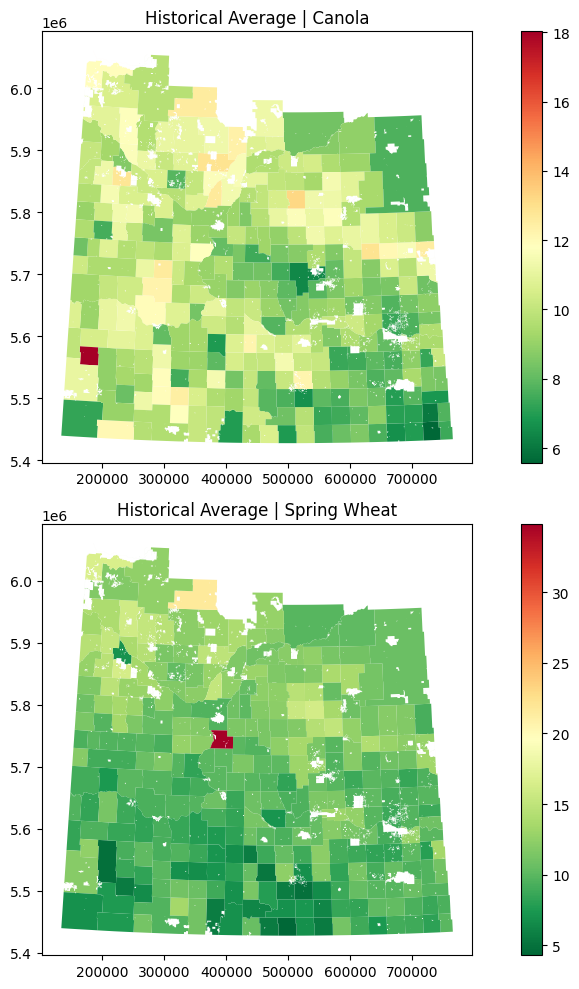

In [3]:
merged_df = pd.merge(
    gdf_rm_clean.rename(columns={'RMNO': 'RM'}),
    df_00_23.groupby('RM').std(),
    on='RM'
)

# List of crops
crops = ['Canola', 'Spring Wheat']

# Create a subplot for each crop
fig, axes = plt.subplots(nrows=len(crops), figsize=(10, 5 * len(crops)))

# Plot each crop
for i, crop in enumerate(crops):
    merged_df.plot(column=crop, cmap='RdYlGn_r', legend=True, ax=axes[i])
    axes[i].set_title(f'Historical Average | {crop}')

plt.tight_layout()
plt.show()

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train Random Forest models
rf_model_canola = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_canola.fit(X_train_canola, y_train_canola)

rf_model_spring_wheat = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_spring_wheat.fit(X_train_spring_wheat, y_train_spring_wheat)

# Make predictions
canola_predictions_rf = rf_model_canola.predict(X_test_canola)
spring_wheat_predictions_rf = rf_model_spring_wheat.predict(X_test_spring_wheat)

# Evaluate the models
canola_mse_rf = mean_squared_error(y_test_canola, canola_predictions_rf)
spring_wheat_mse_rf = mean_squared_error(y_test_spring_wheat, spring_wheat_predictions_rf)

print("Random Forest - Canola MSE:", canola_mse_rf)
print("Random Forest - Spring Wheat MSE:", spring_wheat_mse_rf)


Random Forest - Canola MSE: 20.17627015251667
Random Forest - Spring Wheat MSE: 30.333662884796446


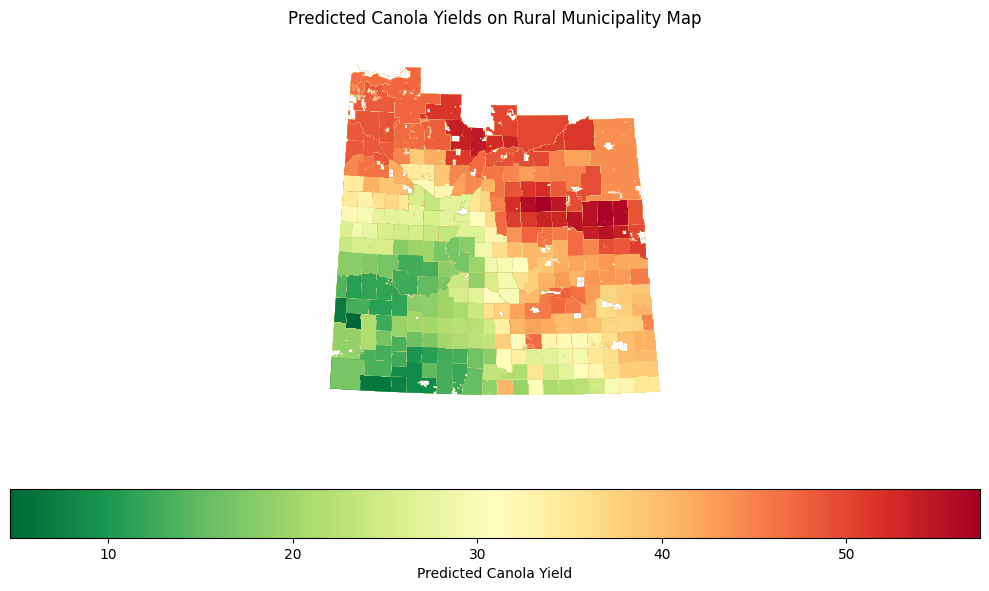

In [24]:
# Predict canola yield for all rural municipalities
all_canola_predictions_rf = rf_model_canola.predict(X[['Year', 'RM']])

# Create DataFrame with predicted canola yields for all RMs
all_canola_results_df = pd.DataFrame({
    'RM': X['RM'],  # Rural Municipality
    'Predicted_Canola_Yield': all_canola_predictions_rf  # Predicted canola yield using Random Forest
})

# Merge with GeoDataFrame to get geometries
merged_all_canola_df = pd.merge(gdf_rm_clean, all_canola_results_df, on='RM', how='inner')

# Plot predicted canola yield on map
fig, ax = plt.subplots(figsize=(10, 6))

# Plot predicted canola yield
merged_all_canola_df.plot(column='Predicted_Canola_Yield', cmap='RdYlGn_r', legend=True, ax=ax,
                          legend_kwds={'label': "Predicted Canola Yield", 'orientation': "horizontal"})

# Add title and show the plot
plt.title('Predicted Canola Yields on Rural Municipality Map')
plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()


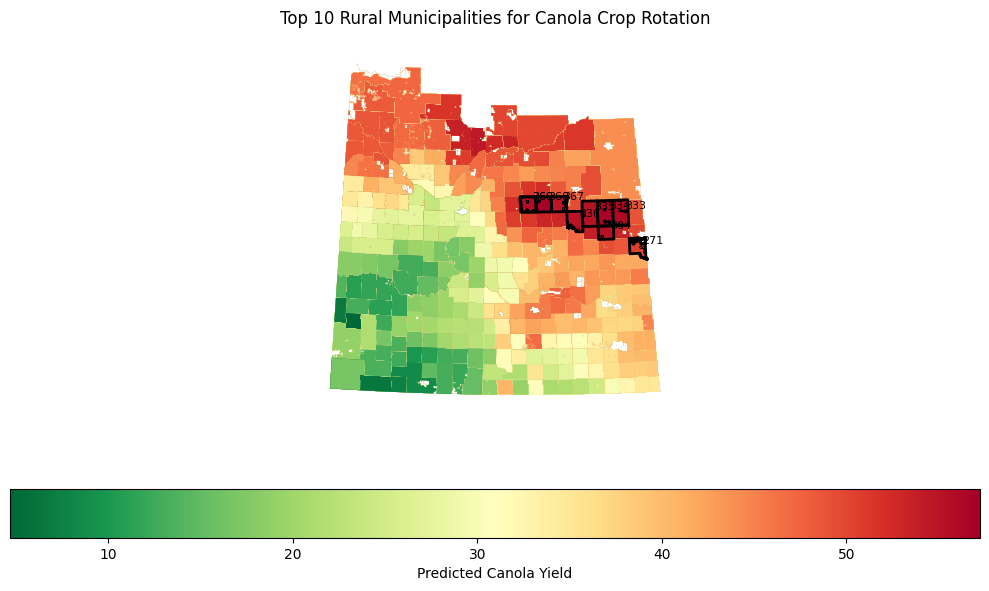

In [25]:
# Sort rural municipalities by predicted canola yield
top_rms_canola = merged_all_canola_df.sort_values(by='Predicted_Canola_Yield', ascending=False).head(10)

# Plot the top-ranked rural municipalities on the map
fig, ax = plt.subplots(figsize=(10, 6))

# Plot predicted canola yield for all rural municipalities
merged_all_canola_df.plot(column='Predicted_Canola_Yield', cmap='RdYlGn_r', legend=True, ax=ax,
                          legend_kwds={'label': "Predicted Canola Yield", 'orientation': "horizontal"})

# Plot the top-ranked rural municipalities
top_rms_canola.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Annotate the top-ranked rural municipalities with their names
for x, y, label in zip(top_rms_canola.geometry.centroid.x, top_rms_canola.geometry.centroid.y, top_rms_canola['RM']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

# Add title and show the plot
plt.title('Top 10 Rural Municipalities for Canola Crop Rotation')
plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()


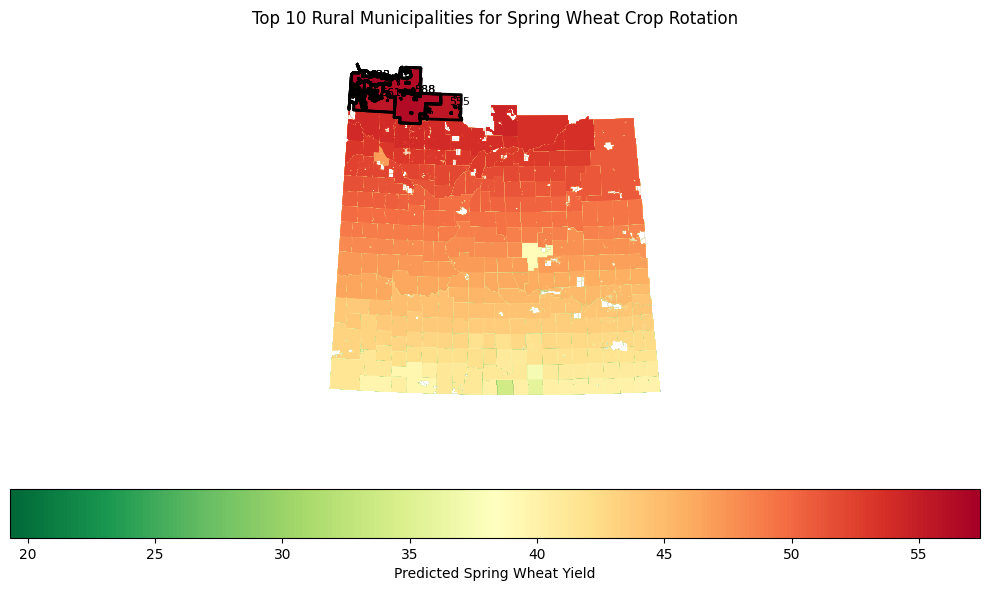

In [31]:
# Sort rural municipalities by predicted spring wheat yield
top_rms_spring_wheat = merged_all_spring_wheat_df.sort_values(by='Predicted_Spring_Wheat_Yield', ascending=False).head(10)

# Plot the top-ranked rural municipalities on the map
fig, ax = plt.subplots(figsize=(10, 6))

# Plot predicted spring wheat yield for all rural municipalities
merged_all_spring_wheat_df.plot(column='Predicted_Spring_Wheat_Yield', cmap='RdYlGn_r', legend=True, ax=ax,
                                legend_kwds={'label': "Predicted Spring Wheat Yield", 'orientation': "horizontal"})

# Plot the top-ranked rural municipalities
top_rms_spring_wheat.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Annotate the top-ranked rural municipalities with their names
for x, y, label in zip(top_rms_spring_wheat.geometry.centroid.x, top_rms_spring_wheat.geometry.centroid.y, top_rms_spring_wheat['RM']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

# Add title and show the plot
plt.title('Top 10 Rural Municipalities for Spring Wheat Crop Rotation')
plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()



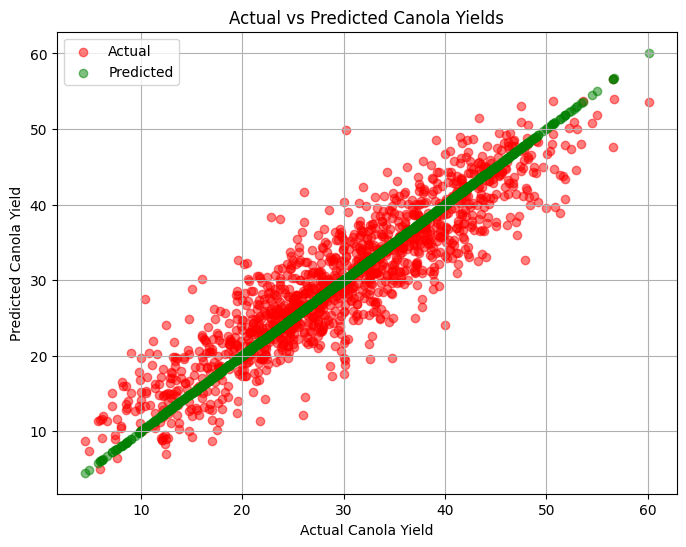

In [34]:
# Plot scatter plot of actual vs predicted canola yields with legend and colored points
plt.figure(figsize=(8, 6))
plt.scatter(canola_comparison_df['Actual_Canola_Yield'], canola_comparison_df['Predicted_Canola_Yield'], color='red', alpha=0.5, label='Actual')
plt.scatter(canola_comparison_df['Actual_Canola_Yield'], canola_comparison_df['Actual_Canola_Yield'], color='green', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Canola Yields')
plt.xlabel('Actual Canola Yield')
plt.ylabel('Predicted Canola Yield')
plt.grid(True)
plt.legend()
plt.show()

